In [ ]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Regression with a Real Dataset

This Colab uses a real dataset to predict the prices of houses in California.   






https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_a_real_dataset.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=linear_regression_real_tf2-colab&hl=en

Modified for my own learning

## The Dataset
  
The [dataset for this exercise](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California. The dataset is old but still provides a great opportunity to learn about machine learning programming.

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print(tf.__version__)

2.4.1


## The dataset

Datasets are often stored on disk or at a URL in [.csv format](https://wikipedia.org/wiki/Comma-separated_values). 

A well-formed .csv file contains column names in the first row, followed by many rows of data.  A comma divides each value in each row. For example, here are the first five rows of the .csv file file holding the California Housing Dataset:

```
"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
```



### Load the .csv file into a pandas DataFrame

The following code cell imports the .csv file into a pandas DataFrame and scales the values in the label (`median_house_value`):

In [2]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
training_df["median_house_value"] /= 1000.0

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


Scaling `median_house_value` puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.  

Although scaling a label is usually *not* essential, scaling features in a multi-feature model usually *is* essential.

## Examine the dataset

A large part of most machine learning projects is getting to know your data. The pandas API provides a `describe` function that outputs the following statistics about every column in the DataFrame:

* `count`, which is the number of rows in that column. Ideally, `count` contains the same value for every column. 

* `mean` and `std`, which contain the mean and standard deviation of the values in each column. 

* `min` and `max`, which contain the lowest and highest values in each column.

* `25%`, `50%`, `75%`, which contain various [quantiles](https://developers.google.com/machine-learning/glossary/#quantile).

In [3]:
# Get statistics on the dataset.
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Task 1: Identify anomalies in the dataset

Do you see any anomalies (strange values) in the data? 

A: Max of several quantities is >~ 1000% of the 75% quartile, suggesting some potentially anomalous values there

<AxesSubplot:>

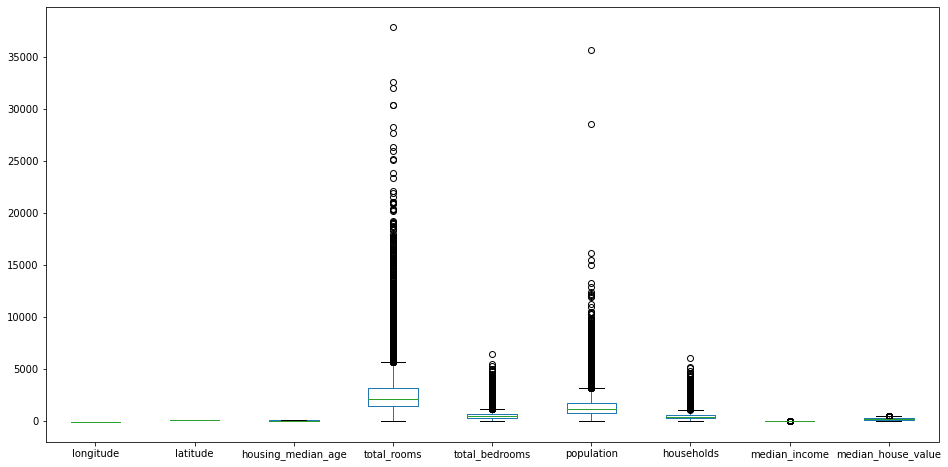

In [28]:
training_df.plot.box(figsize=(16, 8))

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [29]:
def build_model(my_learning_rate):
    """Create and compile a simple linear regression model."""
    model = tf.keras.models.Sequential()

    # The topography of a simple linear regression model is a single node in a single layer.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # Configure training to minimize the model's mean squared error. 
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model        


def train_model(model, df, feature, label, epochs, batch_size):
    """Train the model by feeding it data."""
    history = model.fit(x=df[feature], y=df[label], batch_size=batch_size, epochs=epochs)

    # Gather the trained model's weight and bias.
    trained_weight, trained_bias = model.get_weights()

    epochs = history.epoch
  
    # Isolate the error for each epoch.
    hist = pd.DataFrame(history.history)

    rmse = hist["root_mean_squared_error"]

    return trained_weight, trained_bias, epochs, rmse

## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [31]:
def plot_the_model(trained_weight, trained_bias, feature, label):
    """Plot the trained model against 200 random training examples."""
    plt.xlabel(feature)
    plt.ylabel(label)

    # Create a scatter plot from 200 random points of the dataset.
    # random_examples = training_df.sample(n=200)
    random_examples = training_df
    plt.scatter(random_examples[feature], random_examples[label])

    # Create a red line representing the model. The red line starts
    # at coordinates (x0, y0) and ends at coordinates (x1, y1).
    x0 = 0
    y0 = trained_bias
    x1 = 10000
    y1 = trained_bias + (trained_weight * x1)
    plt.plot([x0, x1], [y0, y1], c='r')

    plt.show()


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.show()  

## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
567/567 [==============================] - 0s 483us/step - loss: 1548439.0495 - root_mean_squared_error: 1141.2949
Epoch 2/30
567/567 [==============================] - 0s 582us/step - loss: 29004.2717 - root_mean_squared_error: 170.2483
Epoch 3/30
567/567 [=============================

/home/tb/.virtualenvs/dev/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


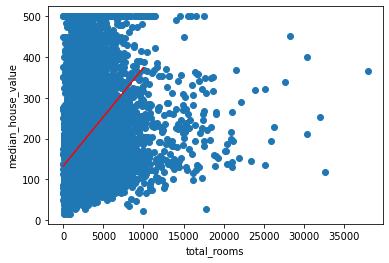

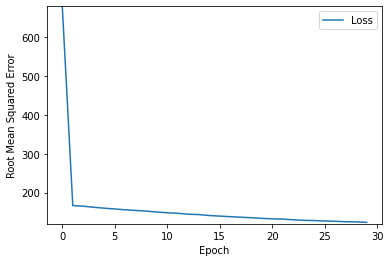

In [34]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
my_feature = "total_rooms"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on total_rooms.  

# Discard any pre-existing version of the model.
my_model = None
del my_model

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(
    my_model, training_df, my_feature, my_label, epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [35]:
def predict_house_values(n, feature, label):
    """Predict house values based on a feature."""

    batch = training_df[feature][10000:10000 + n]
    predicted_values = my_model.predict_on_batch(x=batch)

    print("feature   label          predicted")
    print("  value   value          value")
    print("          in thousand$   in thousand$")
    print("--------------------------------------")
    for i in range(n):
      print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                     training_df[label][10000 + i],
                                     predicted_values[i][0] ))

Now, invoke the house prediction function on 10 examples:

In [36]:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1960     53             180
 3400     92             215
 3677     69             221
 2202     62             186
 2403     80             191
 5652    295             269
 3318    500             213
 2552    342             194
 1364    118             166
 3468    128             216


### Task 2: Judge the predictive power of the model

Look at the preceding table. How close is the predicted value to the label value?  In other words, does your model accurately predict house values?  

A: No.

In [47]:
diff = my_model.predict_on_batch(x=training_df[my_feature][10000:10010]).squeeze() - training_df[my_label][10000:10010]
diff.abs().mean()

123.36008046875001

## Task 3: Try a different feature

The `total_rooms` feature had only a little predictive power. Would a different feature have greater predictive power?  Try using `population` as the feature instead of `total_rooms`. 

Note: When you change features, you might also need to change the hyperparameters.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
3400/3400 [==============================] - 2s 563us/step - loss: 53929.6487 - root_mean_squared_error: 219.5516
Epoch 2/25
3400/3400 [==============================] - 1s 430us/step - loss: 26809.0885 - root_mean_squared_error: 163.6892
Epoch 3/25
3400/3400 [==============================] - 2s 609us/step - loss: 23858.3998 - root_mean_squared_error: 154.4473
Epoch 4/25
3400/3400 [==============================] - 2s 443us/step - loss: 22533.8396 - root_mean_squared_error: 150.0682
Epoch 5/25
3400/3400 [==============================] - 2s 656us/step - loss: 19366.6545 - root_mean_squared_error: 139.1453
Epoch 6/25
3400/3400 [=

/home/tb/.virtualenvs/dev/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


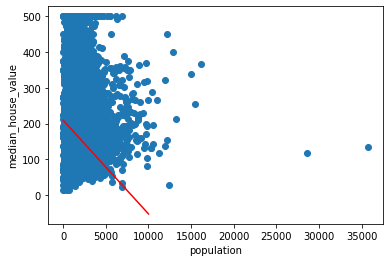

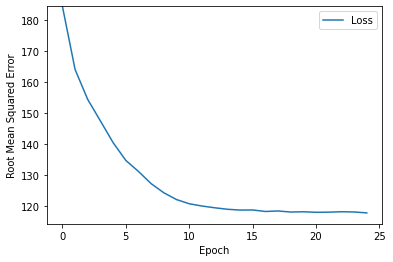

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1286     53             176
 1867     92             160
 2191     69             152
 1052     62             182
 1647     80             166
 2312    295             149
 1604    500             167
 1066    342             181
  338    118             200
 1604    128             167
 1200    187             178
  292     80             202
 2014    112             156
 1817     95             162
 1328     69             174


In [59]:
my_feature = "population"   # Replace the ? with population or possibly a different column name.

# Experiment with the hyperparameters.
learning_rate = 0.01
epochs = 25
batch_size = 5

my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(
    my_model, training_df, my_feature, my_label, epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

Did `population` produce better predictions than `total_rooms`?

A: It's slightly better in performance for majority of samples

In [63]:
diff = my_model.predict_on_batch(x=training_df[my_feature][10000:10010]).squeeze() - training_df[my_label][10000:10010]
diff.abs().mean(), diff.std()

(124.11736196289064, 154.42467438884955)

## Task 4: Define a synthetic feature

You have determined that `total_rooms` and `population` were not useful features.  That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the *ratio* of `total_rooms` to `population` might have some predictive power. That is, perhaps block density relates to median house value.

To explore this hypothesis, do the following: 

1. Create a [synthetic feature](https://developers.google.com/machine-learning/glossary/#synthetic_feature) that's a ratio of `total_rooms` to `population`. (If you are new to pandas DataFrames, please study the [Pandas DataFrame Ultraquick Tutorial](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en).)
2. Tune the three hyperparameters.
3. Determine whether this synthetic feature produces 
   a lower loss value than any of the single features you 
   tried earlier in this exercise.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
567/567 [==============================] - 1s 636us/step - loss: 56683.7492 - root_mean_squared_error: 238.0503
Epoch 2/25
567/567 [==============================] - 0s 720us/step - loss: 48837.0822 - root_mean_squared_error: 220.9759
Epoch 3/25
567/567 [==============================] - 0s 749us/step - loss: 42831.5699 - root_mean_squared_error: 206.9461
Epoch 4/25
567/567 [==============================] - 0s 681us/step - loss: 37153.3795 - root_mean_squared_error: 192.7376
Epoch 5/25
567/567 [==============================] - 0s 752us/step - loss: 32512.0627 - root_mean_squared_error: 180.2758
Epoch 6/25
567/567 [=============

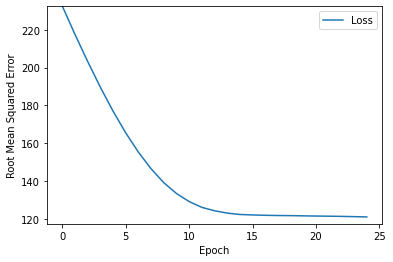

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             179
    2     92             196
    2     69             187
    2     62             211
    1     80             175
    2    295             231
    2    500             210
    2    342             228
    4    118             321
    2    128             215
    2    187             230
    3     80             244
    2    112             231
    2     95             222
    2     69             210


In [65]:
# Define a synthetic feature named rooms_per_person
training_df["rooms_per_person"] = training_df.total_rooms / training_df.population

# Don't change the next line.
my_feature = "rooms_per_person"

# Assign values to these three hyperparameters.
learning_rate = 0.01
epochs = 25
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(
    my_model, training_df, my_feature, my_label, epochs, batch_size)

plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

Based on the loss values, this synthetic feature produces a better model than the individual features you tried in Task 2 and Task 3. However, the model still isn't creating great predictions.


## Task 5. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two column's [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [69]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0


The correlation matrix shows nine potential features (including a synthetic
feature) and one label (`median_house_value`).  A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.  

**Your Task:** Determine which of the nine potential features appears to be the best candidate for a feature?

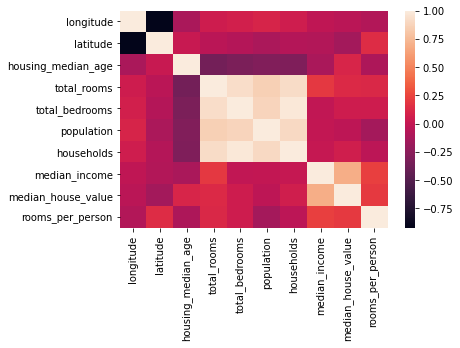

'median_income'

In [81]:
import seaborn as sns

corr = training_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

corr.median_house_value.drop('median_house_value').abs().idxmax()

median_income seems like a pretty good feature here

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
567/567 [==============================] - 1s 752us/step - loss: 56359.8630 - root_mean_squared_error: 237.3372 0s - loss: 56852.5203 - root_mean_squared_error: 238.38
Epoch 2/15
567/567 [==============================] - 1s 988us/step - loss: 44133.7746 - root_mean_squared_error: 210.0076
Epoch 3/15
567/567 [==============================] - 0s 863us/step - loss: 33238.1393 - root_mean_squared_error: 182.2580
Epoch 4/15
567/567 [==============================] - 0s 829us/step - loss: 24922.0559 - root_mean_squared_error: 157.7954
Epoch 5/15
567/567 [==============================] - 0s 765us/step - loss: 17713.7339 - root_mean_s

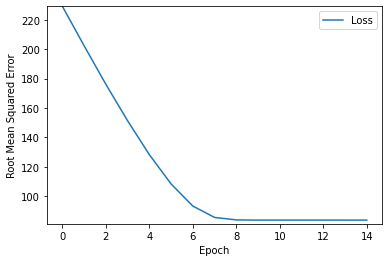

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2     53             134
    4     92             212
    3     69             154
    2     62             132
    3     80             153
    2    295             148
   10    500             456
    5    342             260
    2    118             147
    4    128             221
    8    187             396
    3     80             163
    3    112             179
    4     95             221
    2     69             143


In [83]:
# Run training again using median_income
my_feature = "median_income"

# Assign values to these three hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(
    my_model, training_df, my_feature, my_label, epochs, batch_size)

plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

Correlation matrices don't tell the entire story. In later exercises, you'll find additional ways to unlock predictive power from potential features.

**Note:** Using `median_income` as a feature may raise some ethical and fairness
issues. Towards the end of the course, we'll explore ethical and fairness issues.